In [1]:
import numpy as np
import PIL 
import os
import cv2 as cv
import matplotlib.pyplot as plt
from SizeRespectingDataset import SizeRespectingDataset
from utils import calc_iou, model_wrapper

from torch.utils.data import Dataset


from torchvision import transforms
from tqdm.notebook import tqdm

import torch
import pytorch_lightning as pl
import torch.nn
import glob

import albumentations as A
import albumentations.pytorch as AP

In [9]:
pip freeze

absl-py==2.0.0
accelerate==0.24.1
aiohttp==3.9.0
aiosignal==1.3.1
albumentations==1.3.1
alembic==1.12.1
angle-emb==0.1.3
anyio==4.0.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
asttokens==2.4.0
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.1.0
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.12.2
bitsandbytes==0.41.2.post2
bleach==6.0.0
boltons==23.1.1
cachetools==5.3.2
catboost==1.2.2
certifi==2023.7.22
cffi==1.15.1
charset-normalizer==3.2.0
click==8.1.7
cmake==3.27.5
colorlog==6.7.0
comm==0.1.4
contourpy==1.1.1
cycler==0.12.0
datasets==2.15.0
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.7
exceptiongroup==1.1.3
executing==1.2.0
fastjsonschema==2.18.0
filelock==3.12.4
fonttools==4.43.0
fqdn==1.5.1
frozenlist==1.4.0
fsspec==2023.9.2
google-auth==2.23.4
google-auth-oauthlib==1.1.0
graphviz==0.20.1
greenlet==3.0.1
grpcio==1.59.3
huggingface-hub==0.18.0
idna==3.4
imageio==2.31.3
ipykernel==6.25.2
ipython==8.15.0
ipython-genutils==0.2.0
ipywidgets==8.1.1
i

In [2]:
train_names = []
with open("./archive/people_segmentation/segmentation/train.txt") as train:
    for line in train.readlines():
        train_names.append(line.strip())

val_names = []
with open("./archive/people_segmentation/segmentation/val.txt") as val:
    for line in val.readlines():
        val_names.append(line.strip())

In [11]:
len(val_names), len(train_names)

(568, 5110)

In [3]:
horizontal_train_transforms = A.Sequential([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, crop_border=True),
    # A.Normalize(max_pixel_value=1),
    # A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.1),
    A.Resize(32*9, 32 * 16),
    AP.ToTensorV2(),
])

horizontal_val_transforms = A.Sequential([
    # A.Normalize(max_pixel_value=1),
    A.Resize(32*9, 32 * 16),
    AP.ToTensorV2(),
])

vertical_train_transforms = A.Sequential([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, crop_border=True),
    # A.Normalize(max_pixel_value=1),
    # A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.1),
    A.Resize(32*16, 32 * 9),
    AP.ToTensorV2(),
])

vertical_val_transforms = A.Sequential([
    # A.Normalize(max_pixel_value=1),
    A.Resize(32*16, 32 * 9),
    AP.ToTensorV2(),
])

square_train_transforms = A.Sequential([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, crop_border=True),
    # A.Normalize(max_pixel_value=1),
    # A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.1),
    A.Resize(32*12, 32 * 12),
    AP.ToTensorV2(),
])

square_val_transforms = A.Sequential([
    # A.Normalize(max_pixel_value=1),
    A.Resize(32*12, 32 * 12),
    AP.ToTensorV2(),
])

In [4]:
batch_size = 8
train_dataset = SizeRespectingDataset("./archive/people_segmentation/images/",
                                      "./archive/people_segmentation/masks/",
                                      batch_size=batch_size,
                                      filenames=train_names,
                                      transforms=[horizontal_train_transforms,
                                      vertical_train_transforms,
                                      square_train_transforms]
                                      )

val_dataset = SizeRespectingDataset("./archive/people_segmentation/images/",
                                    "./archive/people_segmentation/masks/",
                                    batch_size=batch_size,
                                    filenames=val_names,
                                    transforms=[horizontal_val_transforms,
                                    vertical_val_transforms,
                                    square_val_transforms]
                                    )

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=12)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

In [5]:
from UNet import UNet
from EncodDecod import EncodDecod
from utils import SoftIoULoss
import timm

crit = SoftIoULoss()
model = EncodDecod(timm.create_model("efficientnet_b3_pruned.in1k", pretrained=True))

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

logger = TensorBoardLogger("tb_logs", name="my_model")
trainer = Trainer(logger=logger)

model = model_wrapper(model, crit)

MyModelCheckpoint = ModelCheckpoint(dirpath='runs/EncodDecod/',
                                    filename='EncodDecodEfficient_b3_pruned_in1k-SoftIoULoss-Normalization-{epoch}-{val_iou:.3f}',
                                    monitor='val_iou',
                                    mode='max',
                                    save_top_k=1)

trainer = pl.Trainer(accelerator="gpu", max_epochs=500, check_val_every_n_epoch=1,
                    callbacks=[EarlyStopping(monitor="val_iou",
                                            mode="max",
                                            patience=10), MyModelCheckpoint])

trainer.fit(model, train_batch_gen, val_batch_gen)

In [6]:
model_wrapped = model_wrapper.load_from_checkpoint("runs/EncodDecod/EncodDecodEfficient_b3_pruned_in1k-SoftIoULoss-epoch=75-val_iou=0.885.ckpt",
                                   base=model,
                                   loss_function=crit).cuda()

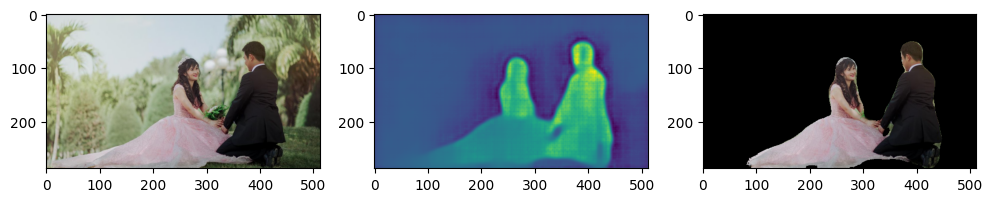

In [7]:
model_wrapped.eval()
with torch.no_grad():
    idx = np.random.choice(5000)
    item = train_dataset[idx]["image"]
    prediction = model_wrapped(item.unsqueeze(0).cuda())
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(item.permute(1,2,0))
    plt.subplot(1, 3, 2)
    plt.imshow(prediction[0, 1, ...].cpu().numpy())
    plt.subplot(1, 3, 3)
    plt.imshow(item.permute(1,2,0) * (prediction[0, ...].cpu().numpy().argmax(axis=0)).astype(np.float32).reshape(*item.shape[1:],1))
    plt.show()

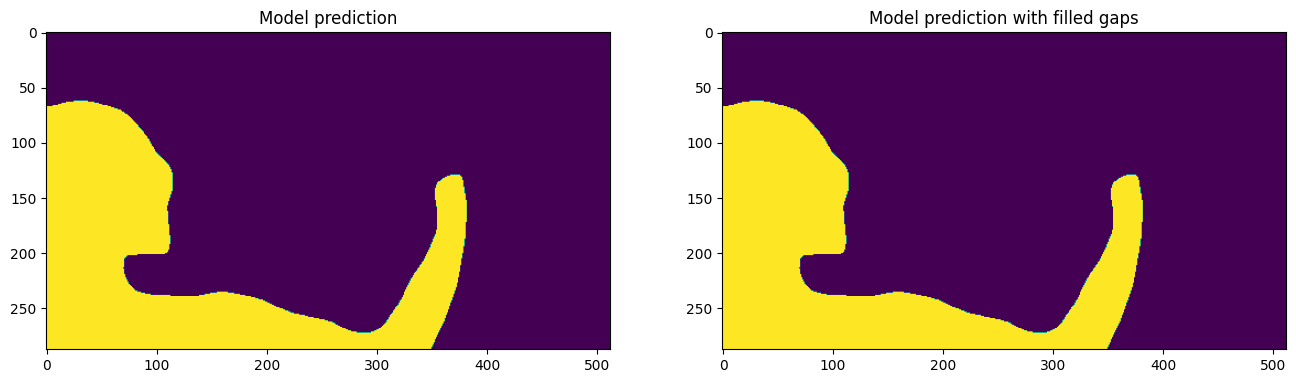

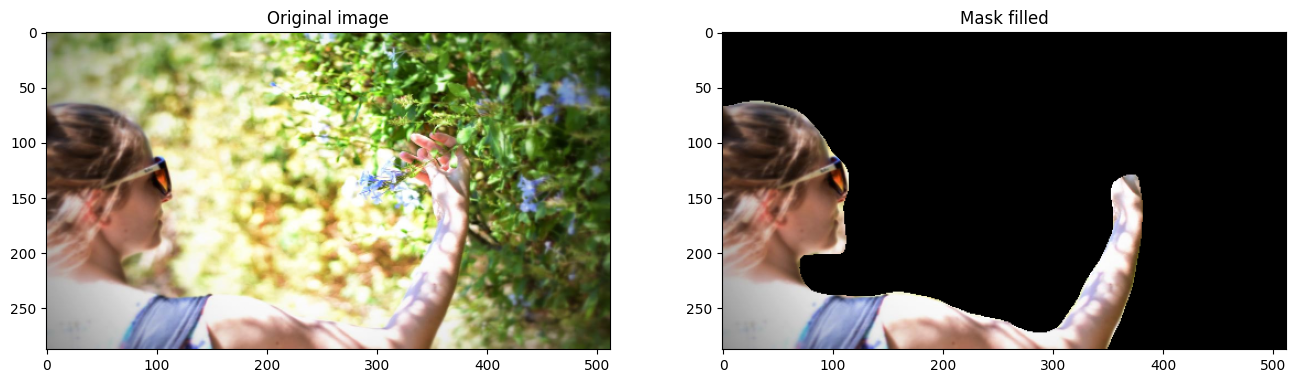

In [193]:
from utils import fill_gaps

model_wrapped.eval()
plt.figure(figsize=(16,6))
with torch.no_grad():
    idx = np.random.choice(500)
    item = val_dataset[idx]["image"]
    prediction = model_wrapped(item.unsqueeze(0).cuda()).squeeze().cpu().numpy().argmax(axis=0)
    plt.subplot(1, 2, 1)
    plt.title("Model prediction")
    plt.imshow(prediction)
    prediction_start = prediction.copy()
    prediction_filled = fill_gaps(prediction)

plt.subplot(1, 2, 2)
plt.title("Model prediction with filled gaps")
plt.imshow(prediction_filled)
plt.show()

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title("Original image")
plt.imshow(item.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title("Mask filled")
plt.imshow(item.permute(1, 2, 0) * prediction_filled.reshape(*item.shape[1:], 1))
plt.show()